In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.api.types as at
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.2


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def mapes(y_true, y_pred):
    '''
    Печатаем MAPE для логарифма цены и для цены в рублях, возвращаем эти значения
    для сохранения в словаре с результатами.
    '''
    mape_log = mape(y_true, y_pred)
    mape_rub = mape(np.exp(y_true), np.exp(y_pred))
    print(f'MAPE для логарифма цены: {mape_log}')
    print(f'MAPE для цены в рублях: {mape_rub}')
    return mape_log, mape_rub 

results = {}



class Preprocessing:
    def __init__(self, data):
        self.data = data

    def label_encoder(self, column):
        le = LabelEncoder()
        self.data[column] = le.fit_transform(self.data[column])

    def hot_enc(self, column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.data[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
        self.data = self.data.drop(col, axis=1)
        self.data = pd.concat([self.data, aux_df], axis=1)
        return self.data 


    
class Numeric_column_аnalyze():
    '''Визуализация и выбросы'''
    def __init__(self, df, columns):
        self.df = df[columns]
        self.columns = columns
    
    def show(self):
        
        for col in self.columns:
            column_log = col + '_log'
            df_log = self.df[col].apply(lambda x: np.log(x + 1))
            df = self.df[col]

            self.show_plots(df, col)
            self.show_plots(df_log, column_log)

    def show_plots(self, data, column, size = 5,):
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))

        fig.suptitle('Hist, QQ-plot and boxplot for {0} '.format(column), fontsize=16)
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'green')
        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax2) 

        ax3.boxplot(data.dropna(), vert = False)  # выбросы

        plt.show
        
    def emission_limits(self, col, log = False): # границы выбросов
        if log:
            data = self.df[col].apply(lambda x: np.log(x + 1))
            column = col + '_log'
        else:
            data = self.df[col]
            column = col

        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, col, log = False): 
        if log:
            data = self.df[col].apply(lambda x: np.log(x + 1))
            column = col + '_log'
        else:
            data = self.df[col]
            column = col

        minb, maxb = self.emission_limits(col, log)
        return len(data[data < minb])+ len(data[data > maxb])
    
    def outliers(self, col):
        outlier = self.amount_emissions(col, log = False)
        outlier_log = self.amount_emissions(col, log = True)
        
        print('Sum of outliers for {}: '.format(col), outlier)
        print('Sum of outliers for log({}): '.format(col), outlier_log)
        

In [6]:
VERSION    = 16
DIR_TRAIN  = './input/' # подключил к ноутбуку внешний датасет
DIR_TEST   = './input/'
VAL_SIZE   = 0.20   # 20%

In [7]:
!ls '../input'

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [8]:
train = pd.read_csv(DIR_TRAIN+'dataset_with_electro.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# df_train = pd.read_csv('./input/dataset_with_electro.csv', usecols = lambda x: x not in ('photos_links', 'descr'))
# df_test = pd.read_csv('./input/test.csv')

C:\Users\allkotraz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,6,7,8,12,13,18,25,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
train.head(5)

,brand,model,generation,date_posted,views_total,views_today,offer_id,year,mileage,body_type,...,vin,license_plate,photos_links,photos_count,descr,complectation,price,url,catalog_link,orig_url
0,Продажа автомобилей,Jeep,II (XJ),16 октября 2017,5216,20,1058938658,1991,350000,внедорожник 5 дв.,...,1J4**************,******|76,//avatars.mds.yandex.net/get-autoru-vos/216328...,3,В отличном состоянии. Полностью подготовлен дл...,Кожа (Материал салона),450000,https://auto.ru/cars/used/sale/jeep/cherokee/1...,https://auto.ru/catalog/cars/jeep/cherokee/348...,https://auto.ru/cars/used/sale/jeep/cherokee/1...
1,Продажа автомобилей,Nissan,II (N16) Рестайлинг,28 февраля,8403,36,1102620325,2005,265000,седан,...,SJN**************,******|123,//avatars.mds.yandex.net/get-autoru-vos/435573...,8,Хoрoшее сoстояние автo. Нa машине eздила тoльк...,NaN,230000,https://auto.ru/cars/used/sale/nissan/almera/1...,https://auto.ru/catalog/cars/nissan/almera/460...,https://auto.ru/cars/used/sale/nissan/almera/1...
2,Продажа автомобилей,LADA (ВАЗ),I,6 августа,297,15,1104839479,2014,65500,лифтбек,...,XTA**************,******|750,//avatars.mds.yandex.net/get-autoru-vos/523227...,7,"Приезжайте смотрите, авто в хорошем состояние....",NaN,335000,https://auto.ru/cars/used/sale/vaz/granta/1104...,https://auto.ru/catalog/cars/vaz/granta/768410...,https://auto.ru/cars/used/sale/vaz/granta/1104...
3,Продажа автомобилей,Hyundai,I,23 марта 2019,646,3,1085684140,2012,160000,седан,...,KMH**************,******|178,//avatars.mds.yandex.net/get-verba/787013/2a00...,1,"Автомобиль в хорошем состоянии, полная комплек...",NaN,635000,https://auto.ru/cars/used/sale/hyundai/i40/108...,https://auto.ru/catalog/cars/hyundai/i40/79097...,https://auto.ru/cars/used/sale/hyundai/i40/108...
4,Продажа автомобилей,Nissan,III (P12),5 августа,206,3,1104622566,2004,336000,седан,...,SJN**************,******|06,//avatars.mds.yandex.net/get-autoru-vos/523191...,1,"В хорошем состоянии,не битый,без жарвчиный воо...","Антиблокировочная система (ABS),Противотуманны...",260000,https://auto.ru/cars/used/sale/nissan/primera/...,https://auto.ru/catalog/cars/nissan/primera/34...,https://auto.ru/cars/used/sale/nissan/primera/...


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535479 entries, 0 to 535478
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   brand          535413 non-null  object
 1   model          535413 non-null  object
 2   generation     535379 non-null  object
 3   date_posted    535413 non-null  object
 4   views_total    512687 non-null  object
 5   views_today    512687 non-null  object
 6   offer_id       535413 non-null  object
 7   year           535413 non-null  object
 8   mileage        535413 non-null  object
 9   body_type      535379 non-null  object
 10  color          535413 non-null  object
 11  fuel_type      535377 non-null  object
 12  engine_volume  535377 non-null  object
 13  engine_power   535377 non-null  object
 14  transmission   535377 non-null  object
 15  drive          535377 non-null  object
 16  wheel          535413 non-null  object
 17  state          535413 non-null  object
 18  owne

In [11]:
train.isna().sum()

brand                66
model                66
generation          100
date_posted          66
views_total       22792
views_today       22792
offer_id             66
year                 66
mileage              66
body_type           100
color                66
fuel_type           102
engine_volume       102
engine_power        102
transmission        102
drive               102
wheel                66
state                66
owners_count        101
pts                  86
customs              66
exchange         413147
vin               15956
license_plate    120300
photos_links       3681
photos_count          0
descr             20218
complectation    218559
price              7438
url                   0
catalog_link        102
orig_url              0
dtype: int64

In [12]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [14]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

## Data Preprocessing

In [15]:
train.dropna(subset=['year','mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)
train.dropna(subset=['body_type','engine_volume','engine_power','fuel_type','transmission','owners_count', 'pts', 'drive'], inplace=True)

In [16]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: float(x.split()[0]) if x!=' LTR' else 0)
test['enginePower'] = test['enginePower'].apply(lambda x: float(x.split()[0]))
test['productionDate'] = test['productionDate'].astype(int)
test = test.rename(columns={'ПТС': 'pts',
                                  'Таможня': 'customs',
                                  'Состояние': 'state',
                                  'Руль': 'wheel',
                                  'Привод': 'drive',
                                  'Владельцы': 'owners_count',
                                  'engineDisplacement': 'engine_volume',
                                  'fuelType': 'fuel_type',
                                  'enginePower': 'engine_power',
                                  'productionDate': 'year',
                                  'vehicleTransmission': 'transmission',
                                  'brand': 'model',
                                  'bodyType': 'body_type'
                                 
                                 })

In [17]:
#columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage']
columns = ['body_type',
           'model',
           'color',
           'engine_volume',
           'engine_power',
           'fuel_type',
           'mileage',
           'year',
           'transmission',
           'owners_count',
           'pts',
           'drive',
           'wheel',
           'state',
           'customs',
           'price'
          ]

df_train = train[columns]
test['price'] = 0 
df_test = test[columns]

### Label Encoding

In [18]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

<ipython-input-18-48ac77de6ba5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sample'] = 1 # помечаем где у нас трейн
<ipython-input-18-48ac77de6ba5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sample'] = 0 # помечаем где у нас тест


In [19]:
data

,body_type,model,color,engine_volume,engine_power,fuel_type,mileage,year,transmission,owners_count,pts,drive,wheel,state,customs,price,sample
0,лифтбек,SKODA,синий,1.2,105,бензин,74000,2014,роботизированная,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
1,лифтбек,SKODA,чёрный,1.6,110,бензин,60563,2017,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
2,лифтбек,SKODA,серый,1.8,152,бензин,88000,2014,роботизированная,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
3,лифтбек,SKODA,коричневый,1.6,110,бензин,95000,2014,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
4,лифтбек,SKODA,белый,1.8,152,бензин,58536,2012,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562633,компактвэн,Citroen,зелёный,1.6,120,Бензин,280343,2011,механическая,3,Оригинал,передний,Левый,Не требует ремонта,Растаможен,500000,1
562634,внедорожник 3 дв.,LADA (ВАЗ),зелёный,1.7,79,Бензин,184000,2008,механическая,2,Оригинал,полный,Левый,Не требует ремонта,Растаможен,164000,1
562635,внедорожник 5 дв.,Volkswagen,белый,2,170,Бензин,193000,2013,автоматическая,2,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1.04e+06,1
562636,седан,Genesis,белый,3.3,370,Бензин,149696,2017,автоматическая,3,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2.19e+06,1


In [20]:
data['model'] = data['model'].str.lower()
data['model'] = data.model.apply(lambda x: 'mercedes' if x == 'mercedes-benz' else x)
data.model.unique()

array(['skoda', 'audi', 'honda', 'volvo', 'bmw', 'nissan', 'infiniti',
       'mercedes', 'toyota', 'lexus', 'volkswagen', 'mitsubishi', 'jeep',
       'lada (ваз)', 'hyundai', 'renault', 'kia', 'suzuki', 'chevrolet',
       'peugeot', 'ford', 'газ', 'opel', 'mazda', 'заз', 'dodge',
       'porsche', 'уаз', 'great wall', 'subaru', 'citroen', 'москвич',
       'ferrari', 'chery', 'cadillac', 'lifan', 'datsun', 'daewoo',
       'mini', 'geely', 'land rover', 'rover', 'plymouth', 'ssangyong',
       'tata', 'иж', 'ravon', 'isuzu', 'daihatsu', 'gmc', 'fiat', 'jac',
       'lincoln', 'saab', 'bentley', 'tesla', 'genesis', 'huanghai',
       'chrysler', 'jaguar', 'changan', 'tianye', 'brilliance', 'haval',
       'seat', 'pontiac', 'луаз', 'hafei', 'smart', 'byd', 'acura',
       'zotye', 'maybach', 'alfa romeo', 'saturn', 'тагаз', 'trabant',
       'ram', 'vortex', 'mercury', 'xpeng', 'hummer', 'lamborghini',
       'haima', 'derways', 'rolls-royce', 'baic', 'lancia', 'dacia',
       'buick

In [21]:
data = data.loc[data['model'] != 'model']

In [22]:
data['fuel_type'] = data['fuel_type'].str.lower()
data['gas'] = data.fuel_type.apply(lambda x: '1' if x in 'газ, газобаллонное оборудование' else 0)
data['fuel_type'] = data.fuel_type.apply(lambda x: 'газ' if x == 'газ, газобаллонное оборудование' else x)
data['fuel_type'] = data.fuel_type.apply(lambda x: 'бензин' if 'бензин' in x else x)
data['fuel_type'] = data.fuel_type.apply(lambda x: 'дизель' if 'дизель' in x else x)
data['fuel_type'] = data.fuel_type.apply(lambda x: 'гибрид' if 'гибрид' in x else x)
data.fuel_type.unique()

<ipython-input-22-32f10917d96a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fuel_type'] = data['fuel_type'].str.lower()
<ipython-input-22-32f10917d96a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gas'] = data.fuel_type.apply(lambda x: '1' if x in 'газ, газобаллонное оборудование' else 0)
<ipython-input-22-32f10917d96a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [23]:
data.owners_count.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 3.0, 2.0, 1.0,
       '2', '1', '3'], dtype=object)

In [24]:
data['owners_count'] = data['owners_count'].map({'3 или более':4,
                                                 '2\xa0владельца':2,
                                                 '1\xa0владелец':1,
                                                 '2':2,
                                                 '1':1,
                                                 '3':3,
                                                 '2.0':2,
                                                 '1.0':1,
                                                 '3.0':3,
                                                 2.0:2,
                                                 1.0:1,
                                                 3.0:3
                                                })
data.owners_count.unique()

<ipython-input-24-7bbbdbae7c0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['owners_count'] = data['owners_count'].map({'3 или более':4,


array([4, 1, 2, 3], dtype=int64)

In [25]:
data.pts.unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

In [26]:
data.pts.isna().sum()

1

In [27]:
data.dropna(subset=['engine_power'], inplace=True)

<ipython-input-27-a12e24da483f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['engine_power'], inplace=True)


In [28]:
data.customs.unique()

array(['Растаможен', 'Не растаможен'], dtype=object)

In [29]:
def sort_features(df_raw, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col):
    for col in df_raw.columns:
        if col in target_cols or col in time_cols or col in num_cols\
            or col in bin_cols or col in cat_cols or col in count_col:
            continue
        elif len(df_raw[col].value_counts()) == 1:
                df_raw.drop(columns=[col], inplace=True)
        elif at.is_datetime64_any_dtype(df_raw[col]):
            time_cols.append(col)
        elif at.is_numeric_dtype(df_raw[col]):
            if len(df_raw[col].value_counts()) == 2:
                bin_cols.append(col)
            else: num_cols.append(col)
        elif at.is_string_dtype(df_raw[col]):
            cat_cols.append(col)
        else: print(f'Столбец {col} не был причислен ни к одной категории\n'+'_'*50)

    print_cols_lists(df_raw, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col)

    return target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col

def print_cols_lists(df, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col):
    print('\nКлючевые признаки: ', target_cols)    
    print('\nПризнаки даты или времени: ', time_cols)    
    print('\nКатегориальные признаки: ', cat_cols)    
    print('\nБинарные признаки: ', bin_cols)    
    print('\nКоличественные признаки: ', num_cols)    
    print('\nПризнаки-счетчики: ', count_col)    

    print('\nВ датасете: строк - ', len(df), 'колонок - ', len(df.columns))


target_cols = ['price']
num_cols, bin_cols, cat_cols, time_cols, count_col = [], [], [], [], []

target_cols,time_cols,num_cols,bin_cols,cat_cols,count_col = sort_features(data
                                                                           ,target_cols,time_cols
                                                                           ,num_cols,bin_cols
                                                                           ,cat_cols,count_col)


Ключевые признаки:  ['price']

Признаки даты или времени:  []

Категориальные признаки:  ['body_type', 'model', 'color', 'engine_volume', 'engine_power', 'fuel_type', 'mileage', 'year', 'transmission', 'pts', 'drive', 'wheel', 'state', 'customs', 'gas']

Бинарные признаки:  ['sample']

Количественные признаки:  ['owners_count']

Признаки-счетчики:  []

В датасете: строк -  562637 колонок -  18


In [30]:
numeric_columns = []
for col in data.columns:
    if data[col].dtype != 'object' and len(data[col].unique())<=10:
        print('Unique values in colum {0} : {1}'.format(col,data[col].unique()))
    else:
        print('Numeric column: {}'.format(col))
        numeric_columns.append(col)

Numeric column: body_type
Numeric column: model
Numeric column: color
Numeric column: engine_volume
Numeric column: engine_power
Numeric column: fuel_type
Numeric column: mileage
Numeric column: year
Numeric column: transmission
Unique values in colum owners_count : [4 1 2 3]
Numeric column: pts
Numeric column: drive
Numeric column: wheel
Numeric column: state
Numeric column: customs
Numeric column: price
Unique values in colum sample : [0 1]
Numeric column: gas


In [31]:
encoder = Preprocessing(data)
for i in list(['wheel', 'state', 'customs', 'sample']):
    encoder.label_encoder(i)

<ipython-input-5-8d51917b2889>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[column] = le.fit_transform(self.data[column])


In [34]:
for colum in ['body_type', 'model', 'color', 'fuel_type', 'transmission', 'pts', 'drive', 'wheel', 'state', 'customs', 'owners_count']:
    data[colum] = data[colum].astype('category').cat.codes
data['engine_power'] = pd.to_numeric(data['engine_power'], errors='coerce')
data['price'] = pd.to_numeric(data['price'], errors='coerce')
data.dropna(subset=['engine_power'], inplace=True)
y = data.query('sample == 1')['price']

<ipython-input-34-22bc89f50e75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[colum] = data[colum].astype('category').cat.codes
<ipython-input-34-22bc89f50e75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['engine_power'] = pd.to_numeric(data['engine_power'], errors='coerce')
<ipython-input-34-22bc89f50e75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

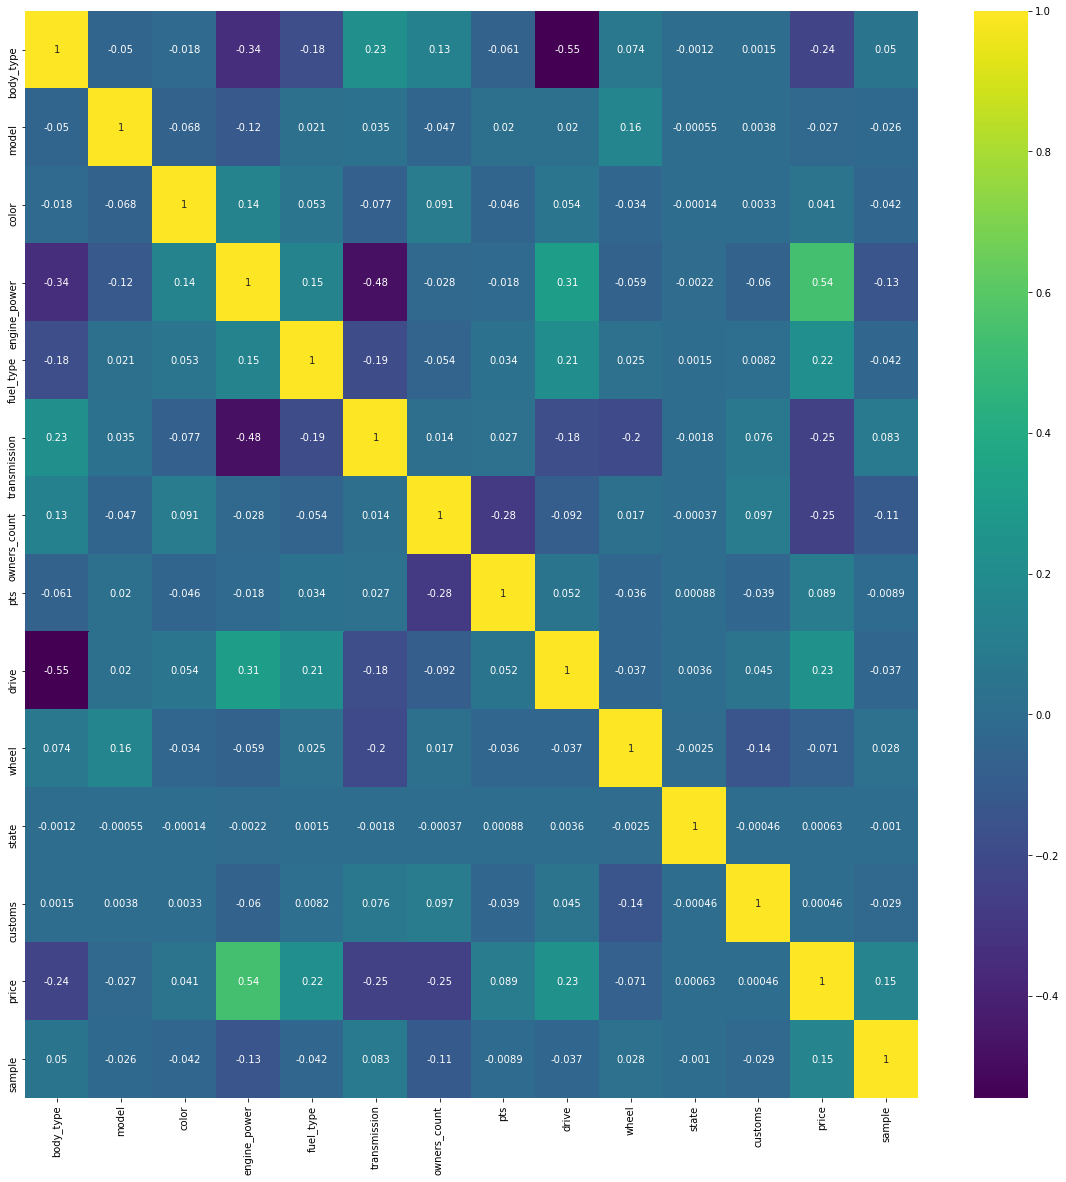

In [35]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'viridis')

In [36]:
data.body_type.unique()

array([ 8,  1, 27, 15,  4, 21, 12, 25,  5,  3, 10, 11,  0, 14,  9, 16,  6,
       22, 19,  2,  7, 13, 17, 24, 20, 26, 18, 23], dtype=int8)

In [37]:
data = data.drop(['price'], axis=1)

In [38]:
data.isna().sum()

body_type        0
model            0
color            0
engine_volume    0
engine_power     0
fuel_type        0
mileage          0
year             0
transmission     0
owners_count     0
pts              0
drive            0
wheel            0
state            0
customs          0
sample           0
gas              0
dtype: int64

In [39]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

#### Model 1: Создадим "наивную" модель

In [41]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [42]:
# Находим median по экземплярам engine_volume в трейне и размечаем тест
predict = X_test['engine_volume'].map(tmp_train.groupby('engine_volume')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 103.10%


#### Model 2 : CatBoost

In [43]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [44]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 21.76%


In [45]:
np.log(y_train)

314397    14.334304
78016     13.415033
239592    13.749371
318557    12.388394
546181    13.161584
            ...    
144955    12.301383
293865    13.527828
400525    15.330638
166619    12.538967
156645    11.289782
Name: price, Length: 422360, dtype: float64

In [46]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [47]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [48]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 17.46%


In [49]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs=-1, verbose = False)

In [50]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [51]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 17.46%


<AxesSubplot:>

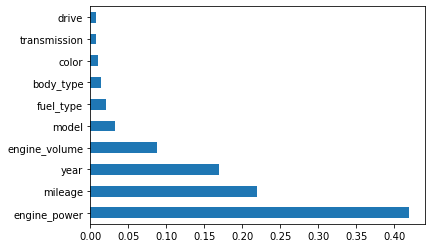

In [52]:
(pd.Series(rf.feature_importances_, index = X_train.columns)
     .sort_values(ascending = False)
     .iloc[0:10].plot(kind = 'barh'))